In [ ]:
import requests
import json
from os.path import expanduser
import numpy as np

# Create a session to persistently store the headers
s = requests.Session()

# Save credentials from JSON file in home directory into session
with open(expanduser('sample_data/consultant_credentials')) as f:
    s.auth = tuple(json.load(f))

# Send a POST request to the /authentication API
response = s.post('https://api.worldquantbrain.com/authentication')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from urllib.parse import urljoin

# Check status code for next action
if response.status_code == requests.status_codes.codes.unauthorized:
    if response.headers["WWW-Authenticate"] == "persona":
        # Outputs the URL to access through the browser to complete biometrics authentication
        input("Complete biometrics authentication and press any key to continue: " + urljoin(response.url, response.headers["Location"]))
        s.post(urljoin(response.url, response.headers["Location"]))
    else:
        print("incorrect email and password")


incorrect email and password


In [ ]:
simulation_data = {
    'type': 'REGULAR',
    'settings': {
        'instrumentType': 'EQUITY',
        'region': 'USA',
        'universe': 'TOP3000',
        'delay': 1,
        'decay': 0,
        'neutralization': 'SLOW',
        'truncation': 1,
        'pasteurization': 'ON',
        'testPeriod': 'P0Y0M',
        'unitHandling': 'VERIFY',
        'nanHandling': 'OFF',
        'language': 'FASTEXPR',
        'visualization': False,
    },
    'regular': 'condition = snt_buzz_bfl == ts_min(snt_buzz_bfl,5);alpha = rank(-ts_delta(close, 3));trade_when(condition, alpha, -1)'
}
simulation_response = s.post('https://api.worldquantbrain.com/simulations', json=simulation_data)


In [ ]:
from time import sleep

simulation_progress_url = simulation_response.headers['Location']
finished = False
while True:
    simulation_progress = s.get(simulation_progress_url)
    if simulation_progress.headers.get("Retry-After", 0) == 0:
        break
    print("Sleeping for " + simulation_progress.headers["Retry-After"] + " seconds")
    sleep(float(simulation_progress.headers["Retry-After"]))
print("Alpha done simulating, getting alpha details")
alpha_id = simulation_progress.json()["alpha"]
alpha = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id)

Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds
Sleeping for 2.5 seconds


In [ ]:
from time import sleep

finished = False
while True:
    pnl = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id + "/recordsets/pnl")
    if pnl.headers.get("Retry-After", 0) == 0:
        break
    print("Sleeping for " + pnl.headers["Retry-After"] + " seconds")
    sleep(float(pnl.headers["Retry-After"]))
print("PnL retrieved")

Sleeping for 1.0 seconds
PnL retrieved


In [ ]:
pnl_json = pnl.json()
pnl_data = pnl_json['records']

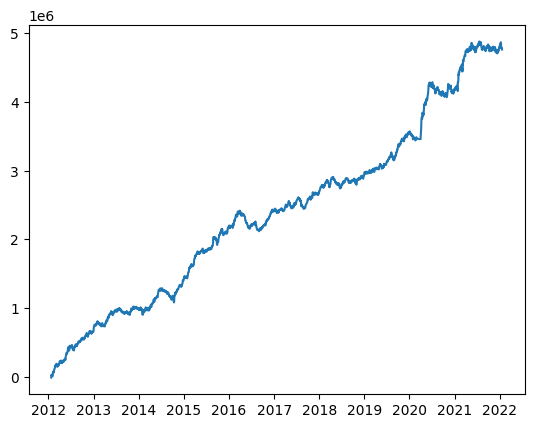

In [ ]:
## Regular plot
import matplotlib.pyplot as plt
from datetime import datetime
dates = [datetime.strptime(item[0], '%Y-%m-%d') for item in pnl_data]
values = [item[1] for item in pnl_data]
plt.plot(dates, values)
plt.show()

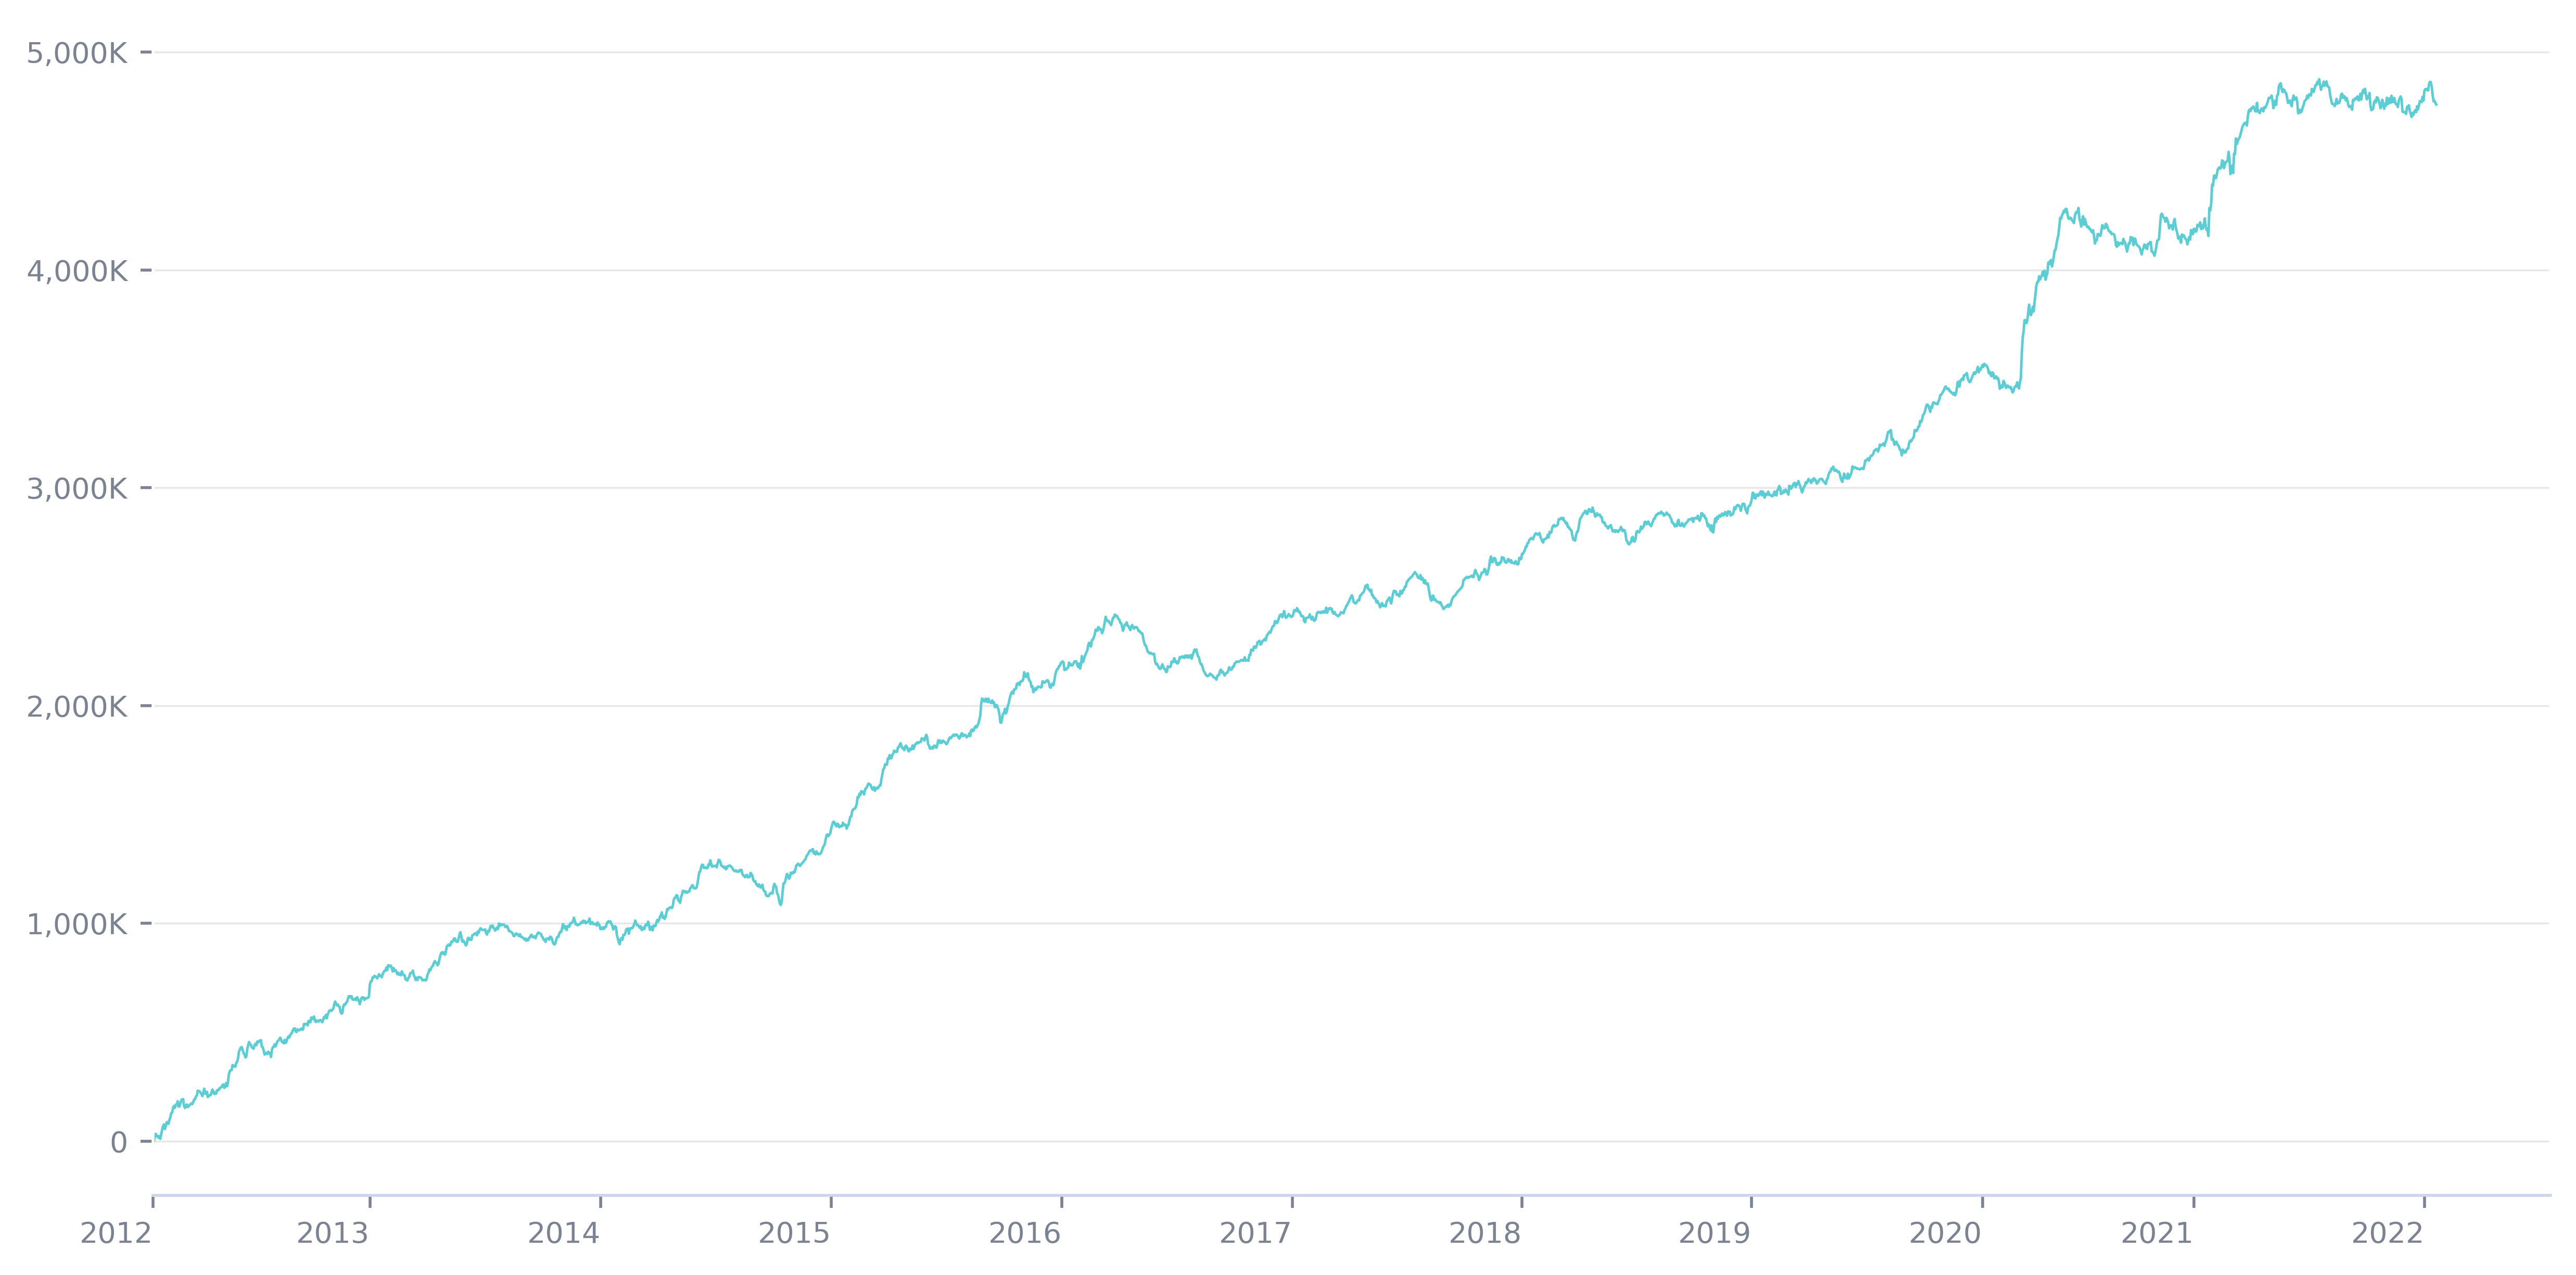

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import FuncFormatter

# Define the formatter function
def y_axis_formatter(x, pos):
    if x >= 1e7:
        label = f'{x*1e-6:,.1f}M' if x % 1e6 != 0 else f'{int(x*1e-6):,}M'
    elif x >= 1e4:
        label = f'{x*1e-3:,.1f}K' if x % 1e3 != 0 else f'{int(x*1e-3):,}K'
    else:
        label = f'{x:,.1f}' if x % 1 != 0 else f'{int(x):,}'
    return label

# Extract dates and values
dates = [datetime.strptime(item[0], '%Y-%m-%d') for item in pnl_data]
values = [item[1] for item in pnl_data]

# Filter and format x-axis ticks (showing only the first available date of every year in data)
first_dates_of_year = []
seen_years = set()
for date in dates:
    year = date.year
    if year not in seen_years:
        first_dates_of_year.append(date)
        seen_years.add(year)

# Create indices for x-axis (0, 1, 2, ..., len(data)-1)
x_indices = [dates.index(date) for date in first_dates_of_year]

# Plot the data with a line joining the points
pig, ax = plt.figure(figsize=(10, 5), facecolor='white', dpi=500), plt.gca()
ax.plot(range(len(dates)), values, linestyle='-', color='#5acdd5', linewidth=0.7)

# Set the x and y-axis ticks and labels
ax.set_xticks(x_indices)
ax.set_xticklabels([date.strftime("%Y") for date in first_dates_of_year], ha='right', color='white')

# Set the background color of the plot area
ax.set_facecolor('white')
ax.grid(True, which='major', axis='y', color='#e6e6e6', linestyle='-', linewidth=0.5)

# Change the color of the axes
ax.spines['bottom'].set_color('#ccd6eb')
ax.spines['left'].set_color('white')
ax.spines['top'].set_color('white')
ax.spines['right'].set_color('white')
ax.tick_params(axis='x', colors='#7b8292', labelsize=8)
ax.tick_params(axis='y', colors='#7b8292', labelsize=8)
ax.yaxis.set_major_formatter(FuncFormatter(y_axis_formatter))

# Customize the plot
plt.xlim(left=0)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
## IS Performance
while True:
    simulation_result = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id)
    if simulation_result.text:
        break
result_json = simulation_result.json()
result_json['is']

{'pnl': 4784723,
 'bookSize': 20000000,
 'longCount': 1533,
 'shortCount': 1575,
 'turnover': 0.4846,
 'returns': 0.0479,
 'drawdown': 0.0299,
 'margin': 0.000198,
 'fitness': 0.67,
 'sharpe': 2.13,
 'startDate': '2012-01-22',
 'checks': [{'name': 'LOW_SHARPE',
   'result': 'PASS',
   'limit': 1.58,
   'value': 2.13},
  {'name': 'LOW_FITNESS', 'result': 'FAIL', 'limit': 1.0, 'value': 0.67},
  {'name': 'LOW_TURNOVER', 'result': 'PASS', 'limit': 0.01, 'value': 0.4846},
  {'name': 'HIGH_TURNOVER', 'result': 'PASS', 'limit': 0.7, 'value': 0.4846},
  {'name': 'CONCENTRATED_WEIGHT', 'result': 'PASS'},
  {'name': 'LOW_SUB_UNIVERSE_SHARPE',
   'result': 'PASS',
   'limit': 0.92,
   'value': 1.12},
  {'name': 'SELF_CORRELATION', 'result': 'PENDING'},
  {'name': 'DATA_DIVERSITY', 'result': 'PENDING'},
  {'name': 'PROD_CORRELATION', 'result': 'PENDING'},
  {'name': 'REGULAR_SUBMISSION', 'result': 'PENDING'},
  {'name': 'MATCHES_COMPETITION',
   'result': 'WARNING',
   'competitions': [{'id': 'MAP

In [ ]:
## Self Correlation
while True:
    simulation_result = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id + "/correlations/self")
    if simulation_result.text:
        break
result_json = simulation_result.json()
result_json

{'schema': {'name': 'selfCorrelation',
  'title': 'Self Correlated',
  'properties': [{'name': 'id', 'title': 'Id', 'type': 'string'},
   {'name': 'name', 'title': 'Name', 'type': 'string'},
   {'name': 'instrumentType', 'title': 'Instrument Type', 'type': 'string'},
   {'name': 'region', 'title': 'Region', 'type': 'string'},
   {'name': 'universe', 'title': 'Universe', 'type': 'string'},
   {'name': 'correlation', 'title': 'Correlation', 'type': 'decimal'},
   {'name': 'sharpe', 'title': 'Sharpe', 'type': 'decimal'},
   {'name': 'returns', 'title': 'Returns', 'type': 'percent'},
   {'name': 'turnover', 'title': 'Turnover', 'type': 'percent'},
   {'name': 'fitness', 'title': 'Fitness', 'type': 'decimal'},
   {'name': 'margin', 'title': 'Margin', 'type': 'permyriad'}]},
 'records': [['no0QX1a',
   'testusa',
   'EQUITY',
   'USA',
   'TOP3000',
   0.4288,
   2.66,
   0.1041,
   0.4194,
   1.33,
   0.000496],
  ['EbXXOEr',
   None,
   'EQUITY',
   'USA',
   'TOP3000',
   0.0589,
   3.37,

In [ ]:
## Prod Correlation
while True:
    simulation_result = s.get("https://api.worldquantbrain.com/alphas/" + alpha_id + "/correlations/prod")
    if simulation_result.text:
        break
result_json = simulation_result.json()
result_json

{'schema': {'name': 'prodCorrelation',
  'title': 'Prod Correlated',
  'properties': [{'name': 'min', 'title': 'Min', 'type': 'decimal'},
   {'name': 'max', 'title': 'Max', 'type': 'decimal'},
   {'name': 'alphas', 'title': '№ Production Alphas', 'type': 'integer'}]},
 'records': [[-1.0, -0.9, 0],
  [-0.9, -0.8, 0],
  [-0.8, -0.7, 2],
  [-0.7, -0.6, 8],
  [-0.6, -0.5, 23],
  [-0.5, -0.4, 75],
  [-0.4, -0.3, 1066],
  [-0.3, -0.2, 14574],
  [-0.2, -0.1, 112821],
  [-0.1, 0.0, 479777],
  [0.0, 0.1, 535233],
  [0.1, 0.2, 245958],
  [0.2, 0.3, 136144],
  [0.3, 0.4, 85567],
  [0.4, 0.5, 60332],
  [0.5, 0.6, 37326],
  [0.6, 0.7, 12202],
  [0.7, 0.8, 2538],
  [0.8, 0.9, 2],
  [0.9, 1, 0]],
 'max': 0.8032,
 'min': -0.7104}